# Practica 1 - Parte 1
## RNN y series temporales
**Nombres:** Felipe Peralta y Samantha Suquilanda

In [ ]:
#  2. Importación de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print(" Librerías importadas correctamente")


 Librerías importadas correctamente


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
Datos cargados: 43800 filas y 8 columnas


C:\Users\samil\AppData\Local\Temp\ipykernel_25084\2180750310.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['pollution'].fillna(0, inplace=True)


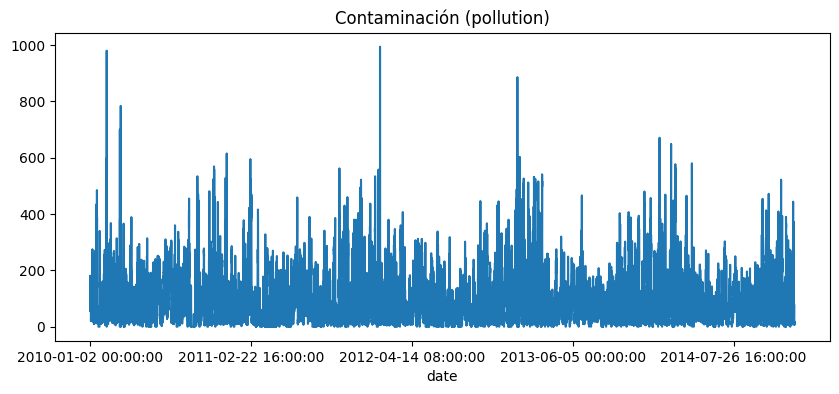

In [ ]:
#  3. Carga y limpieza del dataset
from pandas import read_csv
from datetime import datetime

# Carga del CSV original
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset.head())

# Reemplaza valores nulos
dataset['pollution'].fillna(0, inplace=True)
print(f"Datos cargados: {dataset.shape[0]} filas y {dataset.shape[1]} columnas")

# Gráfico rápido de la variable objetivo
dataset['pollution'].plot(figsize=(10,4), title='Contaminación (pollution)')
plt.show()


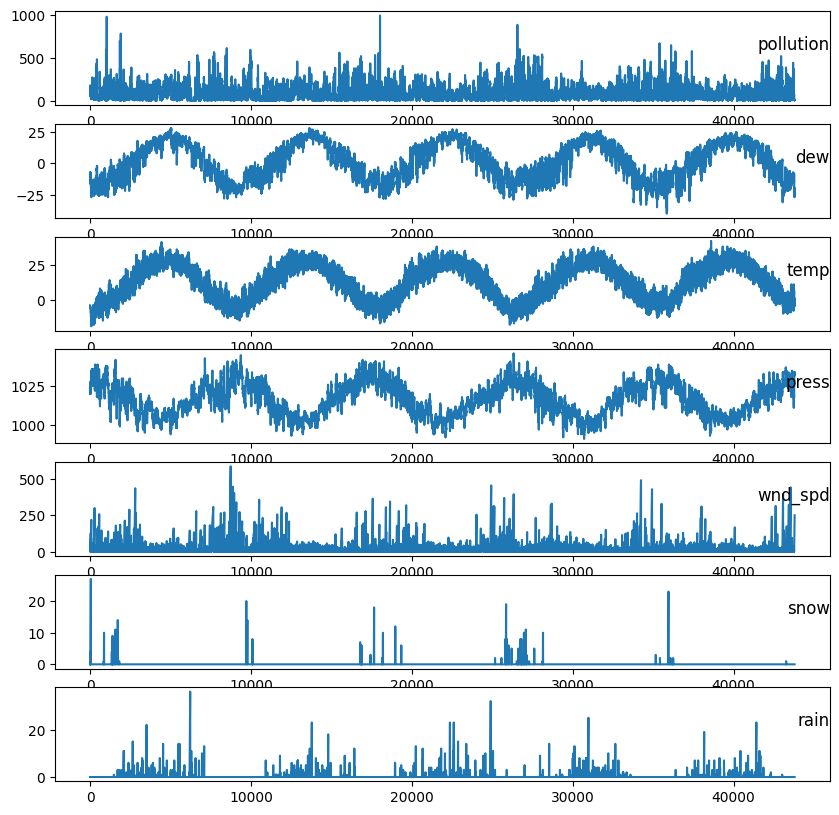

In [ ]:
#  4. Exploración rápida
values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]  
i = 1
plt.figure(figsize=(10, 10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()


In [ ]:
#  5. Transformación a formato supervisado (2 horas)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # entradas pasadas (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    # predicción (t)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
#  6. Codificación y normalización
encoder = LabelEncoder()
dataset['wnd_dir'] = encoder.fit_transform(dataset['wnd_dir'])

values = dataset.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_in, n_out = 2, 1  # Dos horas 
reframed = series_to_supervised(scaled, n_in, n_out)

# Eliminamos salidas 
to_drop = [f'var{i}(t)' for i in range(2, 9)]
reframed.drop(to_drop, axis=1, inplace=True)

print("Forma final del dataset supervisado:", reframed.shape)


Forma final del dataset supervisado: (43798, 17)


In [ ]:
#  7. Preparación de datos para el modelo
values = reframed.values
n_features = 8

n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test  = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X  = test_X.reshape((test_X.shape[0],  n_in, n_features))

print("train_X:", train_X.shape, "train_y:", train_y.shape)
print("test_X:", test_X.shape, "test_y:", test_y.shape)


train_X: (8760, 2, 8) train_y: (8760,)
test_X: (35038, 2, 8) test_y: (35038,)


Epoch 1/50


c:\Users\samil\anaconda3\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 - 1s - 10ms/step - loss: 0.0463 - val_loss: 0.0435
Epoch 2/50
122/122 - 1s - 5ms/step - loss: 0.0235 - val_loss: 0.0371
Epoch 3/50
122/122 - 1s - 4ms/step - loss: 0.0190 - val_loss: 0.0244
Epoch 4/50
122/122 - 1s - 4ms/step - loss: 0.0183 - val_loss: 0.0195
Epoch 5/50
122/122 - 0s - 4ms/step - loss: 0.0179 - val_loss: 0.0183
Epoch 6/50
122/122 - 1s - 5ms/step - loss: 0.0179 - val_loss: 0.0192
Epoch 7/50
122/122 - 1s - 4ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 8/50
122/122 - 1s - 4ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 9/50
122/122 - 1s - 4ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 10/50
122/122 - 1s - 4ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 11/50
122/122 - 1s - 4ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 12/50
122/122 - 1s - 4ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 13/50
122/122 - 1s - 4ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 14/50
122/122 - 1s - 4ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 15/50
122/122 - 1s - 5ms/step - l

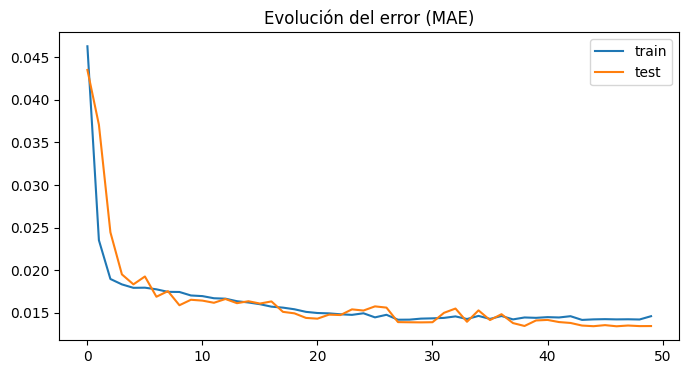

In [ ]:
#  8. Creación y entrenamiento del modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(n_in, n_features)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    train_X, train_y,
    epochs=50, batch_size=72,
    validation_data=(test_X, test_y),
    verbose=2, shuffle=False
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Evolución del error (MAE)")
plt.show()


RMSE: 26.236


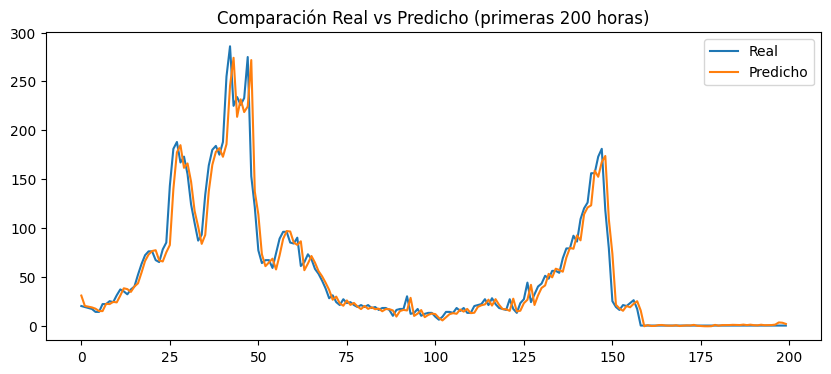

In [ ]:
#  9. Evaluación del modelo
yhat = model.predict(test_X, verbose=0)
test_X_2d = test[:, :-1]

inv_yhat = np.concatenate((yhat, test_X_2d[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

test_y = test[:, -1].reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_2d[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(f'RMSE: {rmse:.3f}')

plt.figure(figsize=(10,4))
plt.plot(inv_y[:200], label='Real')
plt.plot(inv_yhat[:200], label='Predicho')
plt.legend()
plt.title('Comparación Real vs Predicho (primeras 200 horas)')
plt.show()


In [ ]:
#  10. Función de predicción con 2 horas
def predict_next_hour_from_two(x_t2, x_t1, encoder, scaler, model):
    cols = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
    row_t2 = [x_t2[c] for c in cols]
    row_t1 = [x_t1[c] for c in cols]
    if isinstance(row_t2[4], str):
        row_t2[4] = encoder.transform([row_t2[4]])[0]
    if isinstance(row_t1[4], str):
        row_t1[4] = encoder.transform([row_t1[4]])[0]
    X_raw = np.array([row_t2, row_t1], dtype='float32')
    X_scaled = scaler.transform(X_raw)
    X_in = X_scaled.reshape((1, 2, 8))
    yhat = model.predict(X_in, verbose=0)
    last_step = X_scaled[-1]
    inv_base = np.concatenate([yhat.ravel(), last_step[1:]], axis=0).reshape(1, -1)
    yhat_inv = scaler.inverse_transform(inv_base)[:, 0]
    return float(yhat_inv[0])


In [ ]:
#  11. Ejemplo de predicción
x_t2 = {'pollution': 42.0, 'dew': 3.5, 'temp': 17.2, 'press': 1012.0, 'wnd_dir': 'NW', 'wnd_spd': 3.1, 'snow': 0.0, 'rain': 0.0}
x_t1 = {'pollution': 45.0, 'dew': 3.8, 'temp': 17.6, 'press': 1011.5, 'wnd_dir': 'NW', 'wnd_spd': 3.4, 'snow': 0.0, 'rain': 0.0}

pred = predict_next_hour_from_two(x_t2, x_t1, encoder, scaler, model)
print("Predicción de pollution(t):", pred)


Predicción de pollution(t): 44.26696014404297


## Conclusiones

1. Configuración y arquitectura:

- Se entrenó una red neuronal recurrente LSTM utilizando una ventana temporal de 2 horas (16 valores de entrada).

- Esto permite capturar dependencias de corto plazo en la serie temporal.

2. Desempeño del modelo:

- El modelo alcanzó una pérdida MAE ≈ 0.013 y un error RMSE ≈ 26.23, equivalentes a un error relativo <9%.

- Las curvas de entrenamiento y validación muestran convergencia estable y sin sobreajuste.

3. Calidad de las predicciones:

- El modelo logra predecir con alta precisión los valores futuros de contaminación, siguiendo las tendencias reales.

- Los picos de contaminación y los descensos fueron correctamente anticipados por la red.

- Las ligeras desviaciones se presentan en los puntos de cambio abrupto, lo cual es esperable en modelos secuenciales.

4. Predicción puntual:

Para un caso de prueba con pollution(t-2)=42 y pollution(t-1)=45, la red predice pollution(t)≈44.3, manteniendo una tendencia coherente con los datos anteriores.

5. Conclusión general:

- La red LSTM con 2 horas de historia es capaz de aprender patrones temporales complejos en series multivariadas.

- Su rendimiento demuestra que puede utilizarse como una herramienta confiable de predicción a corto plazo, útil en contextos de monitoreo ambiental o pronóstico de variables físicas.
